<h1 style="font-size:40px;"><center>Exercise I:<br> Training of simple MLP models
</center></h1>


# Short summary



In this exercise you will: 

* train MLPs and for simple classification and regression problems.
* learn how hyper parameters such as learning rate, batch size and number of epochs effect the training.

There are 8 questions in this exercise. These 8 questions can be found in three different cells below (see section "The Different Cells"). 

You should write the report of the exercise within this notebook. The details of how to do that can be found below in section "Writing the report". Finally before you start:

**Deadline for submitting the report: November 26, 13:00 (2021)**

### The data
We will use two synthetic different data sets in this exercise

### syn2
The *syn2* dataset represents a binary classification problem. The input data is 2D which allows for an easy visual inspection of the different classes and the decision boundary implemented by the network. The dataset is generated "on the fly" each time. Data are generated from various normal distributions. Since they are generated using random numbers it means that each time you generate the data it will be slightly different from next time. You can control this by having a fixed *seed* to the random number generator. The cell "PlotData" will plot the *syn2* dataset.

### regr1
There is also a synthetic regression problem, called *regr1*. It has one input and one output (target) variable. It a cosinus function, with the possibility to add some noise and dampening on the output. Again see the cell "PlotData" to look at the dataset.

## The exercises
There are 8 questions, where the first 6 questions will use the *regr1* dataset and question 7-8 will use *syn2*.

## The different 'Cells'
This notebook contains several cells with python code, together with the markdown cells (like this one) with only text. Each of the cells with python code has a "header" markdown cell with information about the code. The table below provides a short overview of the code cells. 

| #  |  CellName | CellType | Comment |
| :--- | :-------- | :-------- | :------- |
| 1 | Init | Needed | Sets up the environment|
| 2 | MLP | Needed | Defines the MLP model |
| 3 | Data | Needed | Defines the functions to generate the artificial datasets |
| 4 | PlotData | Information | Plots the 2D classification datasets |
| 5 | Statistics | Needed | Defines the functions that calculates various performance measures |
| 6 | Boundary | Needed | Function that can show 2D classification boundaries | 
| 7 | Ex1 | Exercise | For question 1-4 |
| 8 | Ex2 | Exercise | For question 5-6 |
| 9 | Ex3 | Exercise | For question 7-8 |

In order for you to start with the exercise you need to run all cells with the celltype "Needed". The very first time you start with this exercise we suggest that you enter each of the needed cells, read the cell instruction and run the cell. It is important that you do this in the correct order, starting from the top and work you way down the cells. Later when you have started to work with the notebook it may be easier to use the command "Run All" or "Run all above" found in the "Cell" dropdown menu.

## Writing the report
First the report should be written within this notebook. We have prepared the last cell in this notebook for you where you should write the report. The report should contain 4 parts:

* Name:
* Introduction: A **few** sentences where you give a small introduction of what you have done in the lab.
* Answers to questions: For each of the questions provide an answer. It can be short answers or a longer ones depending on the nature of the questions, but try to be effective in your writing.
* Conclusion: Summarize your findings in a few sentences.

It is important that you write the report in this last cell and **not** after each question! 

## Last but not least
Have fun!

---

# Cells

## CellName: Init (#1)



### CellType: Needed
### Cell instruction: Initializing the libraries

In the cell below, we will import needed libraries. 

Run the cell by entering into the cell and press "CTRL Enter".

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import metrics, regularizers, optimizers
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random as rn
import scipy as sp
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, log_loss, classification_report
import pandas as pd

from tqdm.keras import TqdmCallback

## CellName: MLP (#2)

### CellType: Needed
### Cell instruction: Defining the MLP model
This cell defines the MLP model. There are a number of parameters that is needed to 
define a model. Here is a list of them: **Note:** They can all be specified when you call
this function in later cells. The ones specified in this cell are the default values.

* inp_dim: the input dimension (integer)

* n_nod: size of the network, eg [5] for a one hidden layer with 5 nodes and [5,3] for a two layer network with 5 and 3 hidden nodes each.

* act_fun: the activation function. Most common are
    * 'relu'
    * 'tanh'
        
* out_act_fun: the activation function for the output nodes. Most common are
    * 'linear'
    * 'sigmoid'
    * 'softmax'
    
* opt_method: The error minimization method. Common choices
    * 'SGD'
    * 'Adam'
    
* cost_fun: The error function used during training. There are three common ones
    * 'mean_squared_error'
    * 'binary_crossentropy'
    * 'categorical_crossentropy'

* lr_rate: The learning rate.

* metric: The metric to use besides the loss. Common values
    * accuracy
    * mse

Run the cell by entering into the cell and press "CTRL Enter".

In [3]:
def mlp(inp_dim,
            n_nod,
            act_fun = 'tanh',
            out_act_fun = 'linear',
            opt_method = 'SGD',
            cost_fun = 'mse',
            lr_rate = 0.01,
            metric = 'mse',
            num_out = None):
    
    lays = [inp_dim] + n_nod
    
    main_input = Input(shape=(inp_dim,), dtype='float32', name='main_input')
    
    X = main_input
    for i, nod in enumerate(n_nod):
        X = Dense(nod, 
                  activation = act_fun)(X)
        
    output = Dense(1, activation = out_act_fun )(X)
    
    method = getattr(optimizers, opt_method)
    
    model =  Model(inputs=[main_input], outputs=[output])
    model.compile(optimizer = method(lr = lr_rate),
                  loss = cost_fun,
                  metrics=[metric])       

    return model



## CellName: Data (#3)



### CellType: Needed
### Cell instruction: Defining synthetic data sets

This cell defines the two synthetic datasets. The last function is used for standardization of the data. 

Run the cell by entering into the cell and press "CTRL Enter".

In [4]:
def syn2(N):
    
    global seed
     
    x = np.empty(shape=(N,2), dtype = np.float32)  
    d = np.empty(shape=(N,), dtype = np.float32) 
    N1 = int(N/2)

    # Positive samples
    x[:N1,:] = 0.8 + np.random.normal(loc=.0, scale=1., size=(N1,2))

    # Negative samples 
    x[N1:,:] = -.8 + np.random.normal(loc=.0, scale=1., size=(N-N1,2))
    
    # Target
    d[:N1] = np.ones(shape=(N1,))
    d[N1:] = np.zeros(shape=(N-N1,))

    return x,d


def regr1(N, len = 2, damp=0, v=0):

    global seed

    dx = 2*len*np.pi /(N-1)
    x = np.empty(N, dtype = np.float32) 
    for i in range(N):
        x[i] = i*dx
    
    noise =  lambda  n : np.random.normal(0,1,n)
    if damp == 1:
        d = np.cos(x)*np.exp(-x*0.05)
    else:
        d = np.cos(x)
    
    std_signal = np.std(d)
    d = d + v * std_signal * noise(N)
        
    return x, d


def standard(x):
    return np.mean(x, axis=0) , np.std(x, axis=0)
    

## CellName: PlotData (#4)



### CellType: Information
### Cell instruction: Plotting the data

Here we just generate 100 cases for *syn2* and the *regr1* dataset and plot them. 

Run the cell by entering into the cell and press "CTRL Enter". 

**Note!** This cell is not needed for the actual exercises, it is just to visualize the two datasets.

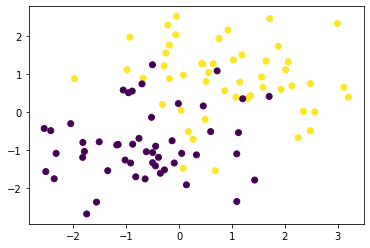

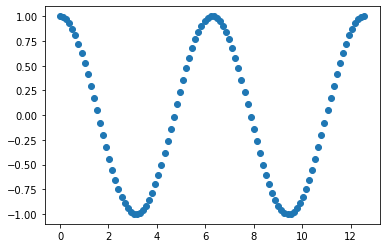

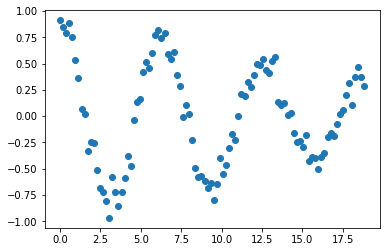

In [5]:
# seed = 0 means random, seed > 0 means fixed
seed = 0
np.random.seed(seed) if seed else None

x,d = syn2(100)
plt.figure(1)
plt.scatter(x[:,0],x[:,1], c=d)

# Regression, one period, no noise
x,d = regr1(100, 2, 0, 0)
plt.figure(2)
plt.scatter(x,d)

# Regression, 1.5 period, exponential damping, some noise
x,d = regr1(100, 3, 1, 0.2)
plt.figure(3)
plt.scatter(x,d)


## CellName: Statistics (#5)



### CellType: Needed
### Cell instruction: Present result for both classification and regression problems

This cell defines two functions that we are going to call using a trained model to calculate both error and performance measures. 

Run the cell by entering into the cell and press "CTRL Enter".

In [6]:
def stats_class(x = None, y = None, label = 'Training', modl = None):
    """
    input :  
             x = input
             y = output
             label = "Provided text string"
             modl = the model
             
    output : 
             accuracy = fraction of correctly classified cases
             loss = typically the cross-entropy error
    """
    
    def binary(y1):
        y1[y1>.5] = 1.
        y1[y1<= .5] = 0.        
        return y1

    y_pr = modl.predict(x, batch_size = x.shape[0], verbose=0).reshape(y.shape)
                
    nof_p, tp, nof_n, tn = [np.count_nonzero(k) for k in [y==1, y_pr[y==1.] > 0.5, y==0, y_pr[y==0.]<= 0.5]]
    
    acc = (tp + tn) / (len(y))
    loss = modl.evaluate(x, y , batch_size =  x.shape[0], verbose=0)
                
    A = ['Accuracy', 'CEE']
    B = [acc, loss[0]]
    
    print('\n','#'*10,'STATISTICS for {} Data'.format(label), '#'*10, '\n')
    for i in range(len(A)):
        print('{:15} {:.4f}'.format(A[i], B[i]))

    return print('\n','#'*50)

def stats_reg(d = None, d_pred = None, label = 'Training', estimat = None):
    
    A = ['MSE']
    
    if label.lower() in ['training', 'trn', 'train']:
        mse = estimat.history['loss'][-1]
    else:
        mse = estimat.history['val_loss'][-1] 

    B = [mse]
    
    print('\n','#'*10,'STATISTICS for {} Data'.format(label), '#'*10, '\n')
    for i in range(len(A)):
        print('{:15} {:.10f}'.format(A[i], B[i]))

    return print('\n','#'*50)


## CellName: Boundary (#6)



### CellType: Needed
### Cell Instruction: Decision boundary

This cell defines the function to plot the decision boundary for a 2D input binary MLP classifier. In short, this function defines a grid covering the input data. Each grid point is then used as an input to the trained MLP and to compute an output. If the output is close to 0.5 it is marked as the boundary. 

Run the cell by entering into the cell and press "CTRL Enter".

In [7]:
def decision_b(X, Y1, model ):
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    # grid stepsize
    h = 0.025

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    Z[Z>.5] = 1
    Z[Z<= .5] = 0

    Y_pr = model.predict(X, batch_size = X.shape[0], verbose=0).reshape(Y1.shape)
  
    Y = np.copy(Y1)
    Y_pr[Y_pr>.5] = 1
    Y_pr[Y_pr<= .5] = 0
    Y[(Y!=Y_pr) & (Y==0)] = 2
    Y[(Y!=Y_pr) & (Y==1)] = 3
    
    
    plt.figure()
    #plt.contourf(xx, yy, Z, cmap=plt.cm.PRGn, alpha = .9) 
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    
    
    plt.scatter(X[:, 0][Y==1], X[:, 1][Y==1], marker='+', c='k')
    plt.scatter(X[:, 0][Y==0], X[:, 1][Y==0], marker='o', c='k')
       
    plt.scatter(X[:, 0][Y==3], X[:, 1][Y==3], marker = '+', c='r')   
    plt.scatter(X[:, 0][Y==2], X[:, 1][Y==2], marker = 'o', c='r')
    
    
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.show()


---
End of "Needed" and "Information" cells. Below are the cells for the actual exercise.

---

# Exercises

## CellName: Ex1 (#7)


### CellType: Exercise
### Cell instruction: Instruction for question 1-


The cell below should be used for questions 1-4.

The following questions will look at three essential parameters that controls the training process of an MLP. By training process we mean here the minimization of the given loss function. The parameters are the *learning rate*, *batch size* and *number of epochs* (or epochs for short). The task is to train an MLP that can fit the *regr1* dataset, i.e. a regression problem. Given the nature of this regression problem we know that we will need more than one hidden node. From experience we know that four hidden nodes are enough to accurately fit the training data, hence we will use four hidden nodes for this first exercise. 

The exercise will study how the learningrate, batchsize and epochs influences the training. A successful training means here when the networks has reached a low loss (< 0.01) and visually have fitted the data accurately. In this exercise we do not care about possible overfitting, only about the minimization of the loss function, we therefore do not have a validation dataset.

#### Question 1
For the first question you can simply run the cell below. It will load 50 samples from the *regr1* dataset (no noise added). The network has 4 hidden nodes in a single hidden layer, *tanh* activation function, linear output activation function, *stochastic gradient descent* as minimization method, MSE loss function, and a learning rate of 0.05.
It will train for 4000 epochs using a batchsize of 50, meaning that we efficiently are using ordinary gradient descent learning. Run this cell five times. **(a) Do you see the same loss vs epoch behavior each time your run?** If no **why?**. **(b) Do you observe that training fails, i.e. do not reach low loss, during these five runs?** 

#### Question 2
You will now study what happens when you train with different learning rates. Train with different learning rates in the range 0.001 to 0.5. Test at least 5 different learning rates in that range and for each learning rate train the network three times and record the average MSE value over these three runs. **Discuss your findings**.

**Note:** You should keep the same settings as for Q1, only vary the learning rate. 

#### Question 3
We now (hopefully) have discovered that the size of the learning rate have an influence of the efficiency of the minimization of the loss function. We will now look at what happens when we use *stochastic gradient descent*, meaning that we will have a batch size that is smaller the the size of the training data. Use a fixed learning rate of 0.05, but test different batch sizes in the range 1 to 50. Again train three different networks for each batch size, but this time record if the training was successful (i.e. MSE < 0.01) and approximately after how many epochs the good solution was found. **Discuss your findings**.

#### Question 4
Now we want to vary both the learning rate and the batch size to find an optimal setting for training this network. Your task is to find a combination of learning rate and batch size that will find a good solution within 1000 epochs. We always have to remember that two runs with identical hyper parameters (e.g. learning rate, batch size etc) will result in different final results. Your set of parameters should *most* for the times result in a good solution within 1000 epochs. **Present your best combination of learning rate and batch size**.


### Code

100%|██████████| 1000/1000 [00:20<00:00, 49.18epoch/s, loss=0.00103, mse=0.00103] 


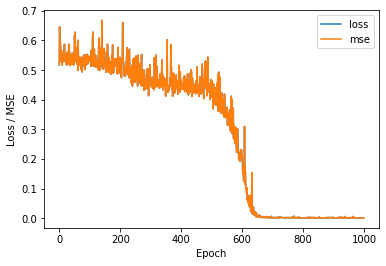


 ########## STATISTICS for Training Data ########## 

MSE             0.0010326584

 ##################################################


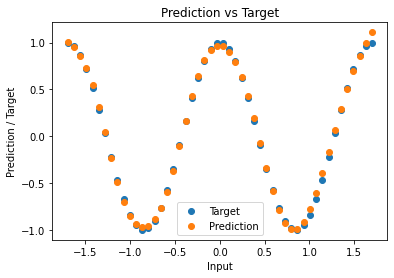

100%|██████████| 1000/1000 [00:21<00:00, 47.58epoch/s, loss=0.00184, mse=0.00184]


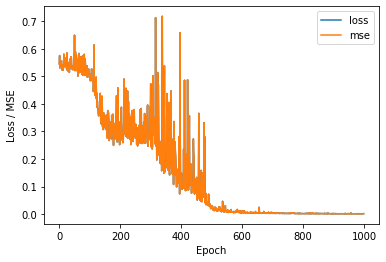


 ########## STATISTICS for Training Data ########## 

MSE             0.0018365191

 ##################################################


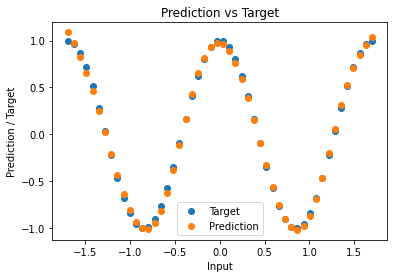

 14%|█▎        | 137/1000 [00:52<05:28,  2.63epoch/s, loss=0.591, mse=0.591]




KeyboardInterrupt: 

 19%|█▉        | 192/1000 [00:20<00:16, 47.55epoch/s, loss=0.511, mse=0.511]

In [47]:
%%time
# seed = 0 means random, seed > 0 means fixed
for i in range(15):
    seed = 0
    np.random.seed(seed) if seed else None

    # Generate training data
    x_trn, d_trn = regr1(50, 2, 0, 0.0)

    # Standardization of inputs
    mu, std = standard(x_trn)
    x_trn = (x_trn - mu)/std

    # Define the network, cost function and minimization method
    INPUT1 = {'inp_dim': 1,         
            'n_nod': [4],                   # number of nodes in hidden layer
            'act_fun': 'tanh',              # activation functions for the hidden layer
            'out_act_fun': 'linear',        # output activation function
            'opt_method': 'SGD',            # minimization method
            'cost_fun': 'mse',              # error function
            'lr_rate': 0.2                 # learningrate
            }        

    # Get the model
    model_ex1 = mlp(**INPUT1)

    # Print a summary of the model
    # model_ex1.summary()

    # Train the model
    estimator_ex1 = model_ex1.fit(x_trn, d_trn,
                                epochs = 1000,      
                                batch_size=10,
                                callbacks = [TqdmCallback(verbose=1)],
                                verbose = 0)


    # Training history
    plt.figure()
    plt.ylabel('Loss / MSE')
    plt.xlabel('Epoch')
    for k in estimator_ex1.history.keys():
        plt.plot(estimator_ex1.history[k], label = k) 
    plt.legend(loc='best')
    plt.show()

    # Call the stat_reg to get MSE
    pred_trn = model_ex1.predict(x_trn).reshape(d_trn.shape)
    stats_reg(d_trn, pred_trn, 'Training', estimator_ex1)

    # Plot the result
    d_pred = model_ex1.predict(x_trn)
    plt.figure()
    plt.ylabel('Prediction / Target')
    plt.xlabel('Input')
    plt.scatter(x_trn, d_trn, label='Target')
    plt.scatter(x_trn, d_pred, label='Prediction')
    plt.title('Prediction vs Target')
    plt.legend(loc='best')
    plt.show()



## CellName: Ex2 (#8)


### CellType: Exercise
### Cell instruction: Instruction for question 5-6


The cell below should be used for questions 5-6.

We have now seen that both learning rate and batch size influence the training efficiency. But there are other aspects as well. The amount of weights in the network can also influence how long time we need to train, and of course if the problem itself is complex or not. The following two questions will try to highlight this.

#### Question 5
The example below will load a slightly more complex *regr1* problem (an additional quarter of a period). We will use 10 hidden nodes for this problem. Use your optimal set of learning rate and batch size as found in Q4 and train the network below. **Compare the number of epochs needed to reach a good solution with that of Q4**.

#### Question 6
This question is a bit more challenging. Use the following line to load the *regr1* data set:

`x_trn, d_trn = regr1(75, 5, 1, 0.0)`

This will create an even more challenging regression task that may need an even larger network. Your task is to find a set of hyper parameters (learning rate, batch size, epochs, 'size of the network') that result in a good solution. You can use more than one hidden layer for this task (if you want). **Present your set of good hyperparameters**. 

**Note:** If you cannot solve this task in *reasonable* time, present your best attempt!


### Code

Model: "model_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 1)]               0         
                                                                 
 dense_279 (Dense)           (None, 10)                20        
                                                                 
 dense_280 (Dense)           (None, 20)                220       
                                                                 
 dense_281 (Dense)           (None, 10)                210       
                                                                 
 dense_282 (Dense)           (None, 1)                 11        
                                                                 
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 8000/8000 [01:58<00:00, 67.61epoch/s, loss=0.00418, mse=0.00418]  


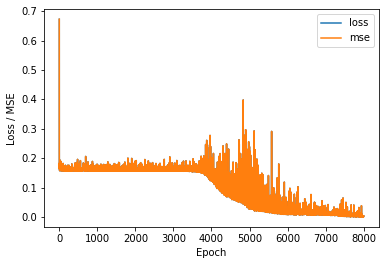


 ########## STATISTICS for Training Data ########## 

MSE             0.0041847434

 ##################################################


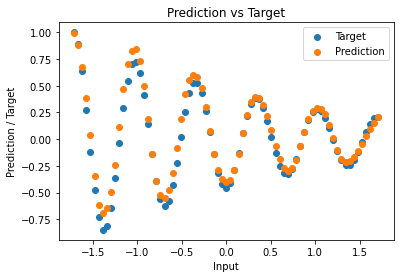

Wall time: 1min 59s


In [88]:
%%time
# seed = 0 means random, seed > 0 means fixed
seed = 0
np.random.seed(seed) if seed else None

# Generate training data
# x_trn, d_trn = regr1(50, 2.5, 0, 0.0)
x_trn, d_trn = regr1(75, 5, 1, 0.0)
# x_trn, d_trn = regr1(175, 5, 1, 0.0)

# Standardization of inputs
mu, std = standard(x_trn)
x_trn = (x_trn - mu)/std

# Define the network, cost function and minimization method
INPUT2 = {'inp_dim': 1,         
         'n_nod': [10, 20, 10],                   # number of nodes in hidden layer
         'act_fun': 'tanh',              # activation functions for the hidden layer
         'out_act_fun': 'linear',        # output activation function
         'opt_method': 'SGD',            # minimization method
         'cost_fun': 'mse',              # error function
         'lr_rate': 0.5                 # learningrate
        }        

# Get the model
model_ex2 = mlp(**INPUT2)

# Print a summary of the model
model_ex2.summary()

# Train the model
estimator_ex2 = model_ex2.fit(x_trn, d_trn,
                              epochs = 8000,      
                              batch_size=40,
                              callbacks = [TqdmCallback(verbose=1)],
                              verbose = 0)


# Training history
plt.figure()
plt.ylabel('Loss / MSE')
plt.xlabel('Epoch')
for k in estimator_ex2.history.keys():
    plt.plot(estimator_ex2.history[k], label = k) 
plt.legend(loc='best')
plt.show()

# Call the stat_reg to get MSE and correlation coefficiant for the scatter plot
pred_trn = model_ex2.predict(x_trn).reshape(d_trn.shape)
stats_reg(d_trn, pred_trn, 'Training', estimator_ex2)

# Plot the result
d_pred = model_ex2.predict(x_trn)
plt.figure()
plt.ylabel('Prediction / Target')
plt.xlabel('Input')
plt.scatter(x_trn, d_trn, label='Target')
plt.scatter(x_trn, d_pred, label='Prediction')
plt.title('Prediction vs Target')
plt.legend(loc='best')
plt.show()


Model: "model_140"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 1)]               0         
                                                                 
 dense_345 (Dense)           (None, 10)                20        
                                                                 
 dense_346 (Dense)           (None, 20)                220       
                                                                 
 dense_347 (Dense)           (None, 10)                210       
                                                                 
 dense_348 (Dense)           (None, 1)                 11        
                                                                 
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 10000/10000 [02:31<00:00, 66.06epoch/s, loss=0.0752, mse=0.0752]


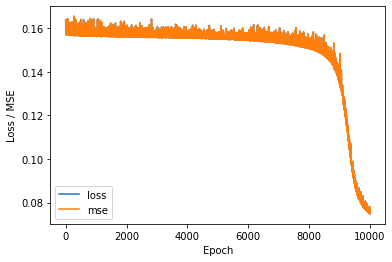


 ########## STATISTICS for Training Data ########## 

MSE             0.0752172470

 ##################################################


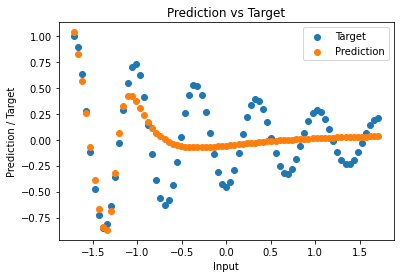

Wall time: 2min 32s


In [108]:
%%time
# seed = 0 means random, seed > 0 means fixed
seed = 0
np.random.seed(seed) if seed else None

# Generate training data
# x_trn, d_trn = regr1(50, 2.5, 0, 0.0)
x_trn, d_trn = regr1(75, 5, 1, 0.0)
# x_trn, d_trn = regr1(175, 5, 1, 0.0)

# Standardization of inputs
mu, std = standard(x_trn)
x_trn = (x_trn - mu)/std

# Define the network, cost function and minimization method
INPUT2 = {'inp_dim': 1,         
         'n_nod': [10, 20, 10],                   # number of nodes in hidden layer
         'act_fun': 'tanh',              # activation functions for the hidden layer
         'out_act_fun': 'linear',        # output activation function
         'opt_method': 'SGD',            # minimization method
         'cost_fun': 'mse',              # error function
         'lr_rate': 0.025                 # learningrate
        }        

# Get the model
model_ex2 = mlp(**INPUT2)

# Print a summary of the model
model_ex2.summary()

# Train the model
estimator_ex2 = model_ex2.fit(x_trn, d_trn,
                              epochs = 10000,      
                              batch_size=25,
                              callbacks = [TqdmCallback(verbose=1)],
                              verbose = 0)


# Training history
plt.figure()
plt.ylabel('Loss / MSE')
plt.xlabel('Epoch')
for k in estimator_ex2.history.keys():
    plt.plot(estimator_ex2.history[k], label = k) 
plt.legend(loc='best')
plt.show()

# Call the stat_reg to get MSE and correlation coefficiant for the scatter plot
pred_trn = model_ex2.predict(x_trn).reshape(d_trn.shape)
stats_reg(d_trn, pred_trn, 'Training', estimator_ex2)

# Plot the result
d_pred = model_ex2.predict(x_trn)
plt.figure()
plt.ylabel('Prediction / Target')
plt.xlabel('Input')
plt.scatter(x_trn, d_trn, label='Target')
plt.scatter(x_trn, d_pred, label='Prediction')
plt.title('Prediction vs Target')
plt.legend(loc='best')
plt.show()


## CellName: Ex3 (#9)


### CellType: Exercise
### Cell instruction: Instruction for question 7


The cell below should be used for questions 7.

We will now look at a classification problem, namely the classification problem defined by the *syn1* dataset.
The cell below defines a single hidden node MLP. With this network you can only implement a linear decision boundary. Run the cell below to look at the resulting boundary that the MLP learns. The training accuracy is around 87-93%, because the data is generated randomly each time you run the code. 

#### Question 7
Your task is now to reach a larger accuracy by fitting a model with more hidden nodes (or more hidden layers). 
Your aim is to reach a training accuracy > 95%. To do that you need to tune the learning rate, batch size, epochs and the size of your MLP. **Present your set of hyper parameters that reach > 95% accuracy**

**Note**: To always generate exactly the same dataset each time you run the code you can set the *seed* to a value > 0. 

#### Question 8
We have so far only used stochastic gradient descent (SGD), but we know that there exists modifications of SGD that are more efficient, e.g. Adam. **Try the Adam optimizer for Q7, and compare (qualitatively) the efficiency in terms of number of epochs needed.

**Info**: For Adam, it is enough for us to use the default values *beta1* = 0.9 and *beta2* = 0.999 

#### Bonus tasks
The bonus tasks are provided if you have extra time and want to continue to explore methods that can further enhance the minimization of the loss function. **These tasks are not required for the course and do not influence any grading**. 

The tasks listed below also mean that you have to change the code in code cell *MLP* (#2). There will be links to appropriate documentation below.

* Go back to Q7 and add use a momentum add-on to SGD. **Does momentum help?** (See documentation [here](https://keras.io/api/optimizers/sgd/))
* It is common to also introduce a mechanism that can lower the learning rate as we train. If we are using stochastic gradient descent the mini-batch gradients will never be zero, meaning that we will always make some small weight updates. Keres have methods that can lower the learning rate as we train (see [here](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/)). Again go back to Q7 and now use an exponential decaying learning rate. **Does it help?**  



### Code

Model: "model_251"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_679 (Dense)           (None, 5)                 15        
                                                                 
 dense_680 (Dense)           (None, 5)                 30        
                                                                 
 dense_681 (Dense)           (None, 1)                 6         
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 500/500 [00:18<00:00, 27.15epoch/s, loss=0.0752, accuracy=0.98]



 ########## STATISTICS for Training Data ########## 

Accuracy        0.9800
CEE             0.0737

 ##################################################


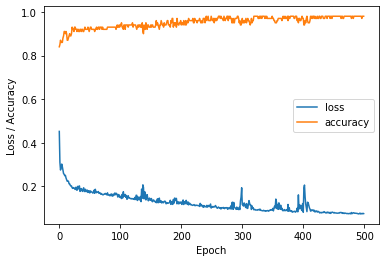

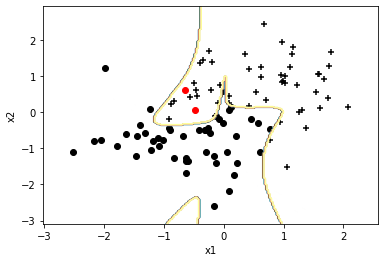

Wall time: 24.7 s


In [224]:
%%time

# seed = 0 means random, seed > 0 means fixed
seed = 0
np.random.seed(seed) if seed else None
    
# Generate training data
x_trn, d_trn = syn2(100)

# General standardization of input data 
mu, std = standard(x_trn)
x_trn = (x_trn - mu)/std

# Define the network, cost function and minimization method
INPUT3 = {'inp_dim': x_trn.shape[1],         
         'n_nod': [5, 5],                      # number of nodes in hidden layer
         'act_fun': 'tanh',                 # activation functions for the hidden layer
         'out_act_fun': 'sigmoid',          # output activation function
        #  'opt_method': 'SGD',               # minimization method
         'opt_method': 'Adam',               # minimization method
         'cost_fun': 'binary_crossentropy', # error function
         'lr_rate': 0.05,                    # learning rate
         'metric': 'accuracy'               # metric for evaluation
        } 

# Get the model
model_ex3 = mlp(**INPUT3)

# Print a summary of the model
model_ex3.summary()

# Train the model
estimator_ex3= model_ex3.fit(x_trn, d_trn,
                      epochs = 500,                
                      batch_size=40,
                      callbacks = [TqdmCallback(verbose=1)],                   
                      verbose = 0)

# Call the stats function to print out statistics for the training
stats_class(x_trn, d_trn, 'Training', model_ex3)

# Training history
plt.figure()
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch')
for k in estimator_ex3.history.keys():
    plt.plot(estimator_ex3.history[k], label = k) 
plt.legend(loc='best')
plt.show()

# Show the decision boundary
decision_b(x_trn, d_trn, model_ex3)


# The report!


### Name: Nils Broman

### Introduction

In this assignment we investigate how different hyperparameters affect the training of a given neural networks and the odds of finding a good model, and how these hyperparameters work together in doing so. We do this by training networks used for regression as well as binary classification problems, while varying these parameters. We also try to freely find good combinations of parameters such that we may find a good model for some tasks.

### Answers to questions

#### 1
a) No. This is due to using random data and the stachasticity in keras, e.g. initialization of random weights b) Yes

#### 2 

| Learning rate | avg MSE |
| ----- | --------- |
| 0.001 | 0.5       |
| 0.01  | 0.47      |
| 0.05  | 0.0031    |
| 0.1   | 0.0013    |
| 0.2   | 0.0012    |
| 0.3   | 0.00057   |
| 0.4   | 0.099     |
| 0.5   | nan       |

For this problem the learning rate 0.3 gave the best results. Using a small learning rate, finding a good fit may take much longer due to the slow learning process or we might get stuck in a local minima, whereas using a too large learning rate may settle for a sub-optimal solution or make the training unstable due to overcorrecting.

#### 3

| Batch size | Epochs run 1 | Epochs run 2 | Epochs run 3 |
| ---------- | ------------ | ------------ | ------------ |
| 5          | 1200         | 300          | 900          |  
| 10         | 500          | 1700         | 1700         |
| 20         | 1800         | 3400         | 300          |
| 30         | 2800         | 900          | --           |
| 40         | 900          | 900          | 1100         |
| 50         | --           | --           | 2000         |

First thing to note is that the results varied quite a lot for the different runs on the same batch size and that one reason for this can be the quality of the data, since we randomly generated it for each run. I would expect this variation to be larger for smaller batch sizes however, since the randomness in what data is used for training is larger, making the early estimates of gradients in training very poor which could slow down the process even more. This often leads to a noisy gradient and could hinder the model from settleing on a minimum. Also, by using small batches, we update the network more frequently which means each epoch will take longer, so in terms of training time it's not neccesarily faster to train only because the number of epochs needed are fewer. Using large batches however, the gradient is typically much smoother, but since it updates less frequently it often means that more epochs are needed. There is also a risk that the model settles for a premature convergence due to this.

To summarize, smaller batches may find solution in fewer epochs, but require more updates per epoch. They are noisy which may hinder the model from converging. Larger batches converges in a smoother fashion, but may take longer to do so, and risk premature converging. This is especially true for the case where the batch size is the entire data set.

#### 4

| Learning rate | Batch size | Mean epochs | Succes rate |
| ------------- | ---------- | ----------- | ----------- |
| 0.2           | 10         | 450         | 85%         | 

Due to updating more frequently and having more noise, a smaller batch size typically has a lower optimum on learning rate. This problem appear to be favoured of a rather large learning rate in general and I've found that using a learning rate of 0.2 with batch size 10 gave good solutions rather quickly (450 epochs) and with a high succes rate at around 85% after more than 20 runs. I was a bit surprised that such high learning rate worked so well with the small batch size, considering the findings in question 3. 

#### 5

| Learning rate | Batch size | Mean epochs | Succes rate |
| ------------- | ---------- | ----------- | ----------- |
| 0.2           | 10         | >5000       | 0%          | 

Using the learning rate and batch size from question 4, this network did not manage to solve the problem within 5000 epochs any of the five times I tested it. I suspect that the learning rate is to large in comparison to the batch size for this problem.

#### 6

| Network size | Learning rate | Batch size | Epochs      | MSE         | Training time |
| ------------ | ------------- | ---------- | ----------- | ----------- | ------------- |
| 20 + 20      | 0.1           | 40         | 10000       | 0.0245      | 2:27          |
| 20 + 20      | 0.05          | 20         | 10000       | 0.0184      | 3:44          |
| 10 + 20 + 10 | 0.3           | 40         | 10000       | 0.0234      | 2:31          |
| **10+20+10** | **0.1**       | **40**     | **10000**   | **0.0149**  | **2:30**      |
| 10 + 20 + 10 | 0.05          | 25         | 10000       | 0.0179      | 2:48          |
| 10 + 20 + 10 | 0.01          | 10         | 10000       | 0.0352      | 6:48          |

For this task, I tested a large selection of models, of different width and depth, varying learning rate and batch size. I tried to find a reasonably small model that could fit in under 5000 epochs but was not able to, and once I allowed for more noticed that most of the models I tested began to show signs of converging soon after, at around 6000-8000 epochs. A few of the models that gave decent results are shown in the table above, where the best model is highlighted in bold face. All these models are much larger than what should be necessary however, but I did not want to go higher than 10000 epochs, where no smaller model managed to come close to converging.

I suspect that this type of problem would benefit of a more sophisticated optimizer. Many of the models became unstable during the later stages of training, and not having a fixed learning rate would probably allow for a much smoother learning process, without having to further increase the number of epochs. This would most likely allow for smaller models to be efficiently trained as well.

#### 7

| Network size | Learning rate | Batch size | Epochs      | 
| ------------ | ------------- | ---------- | ----------- | 
| 10 + 10      | 0.1           | 10         | 1000        |

Using the network with parameters shown in the table above, an average score of 95.7% accuracy was reached over 10 random data sets. By using 1000 epochs the model still averaged 94.5% but needed the extra training in order to break the 95% barrier.  This network consists of 151 parameters, and since the dataset is only of size 100, this is obviously a larger network than necessary.  

| Run          | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | **Avg** |
| ------------ | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---- | ------- |
| Accuracy [%] | 96  | 94  | 95  | 96  | 94  | 97  | 97  | 98  | 94  | 96   | 95.7    |


#### 8

The Adam optimizer performed quite poorly using the same hyperparameters as in question 7, however by lowering learning rate to 0.05 and batch size to 50 it averaged 96.2% after 500 epochs. I accidentally used Adam when I started question 7, but figured that model, shown below, might as well be used to showcase the efficiency.

| Network size | Learning rate | Batch size | Epochs      | 
| ------------ | ------------- | ---------- | ----------- | 
| 5 + 5        | 0.05          | 40         | 500         |

Using the network with parameters shown in the table above, an average score of 95.1% accuracy was reached over 10 random data sets. It is a little less consistent, having larger variance in accuracy, but it uses the third ammount of parameters, together with larger batch size and fewer epochs that reduces training time by almost 90% compared to the model in question 7. 

| Run          | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | **Avg** |
| ------------ | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---- | ------- |
| Accuracy [%] | 99  | 98  | 98  | 93  | 95  | 99  | 92  | 92  | 94  | 91   | 95.1    |

### Summary


From these tasks, we've learned how the basic hyper parameters of network size, learning rate, batch size and epochs, and how they work together, affect the chances of finding a good solution. While doing so, we've also seen a few implementations of MLPs and some areas where it may struggle, e.g. regression on the decaying sine wave. We also gotten a taste of an alternative optimizing method to SGD, namely Adam, and how big of an impact this may have on learning speed.